# Mongo Project

First we will load pymongo and the companies database

In [1]:
from pymongo import MongoClient
import pandas as pd
import seaborn as sns
client=MongoClient()
db=client.companies

After observing the database and working with it in the lab. We will look at which category is the least 'overcrowded'

In [2]:
category = list(db.companies.find({},{'_id':0,'name':1,'category_code':1}))
category = pd.DataFrame(category)
category.head()

,name,category_code
0,AdventNet,enterprise
1,Omnidrive,network_hosting
2,Zoho,software
3,Wetpaint,web
4,Postini,web


After getting our query into a DataFrame we will plot our ocurrences.

web                 3787
software            2736
games_video         1083
mobile              1018
other                986
advertising          928
enterprise           742
ecommerce            688
consulting           637
network_hosting      626
public_relations     533
search               394
biotech              373
hardware             368
cleantech            305
semiconductor        167
security             156
analytics             66
finance               49
social                49
news                  48
education             36
music                 33
messaging             30
legal                 25
medical               25
travel                25
health                23
photo_video           23
manufacturing         19
sports                13
fashion               10
real_estate           10
automotive             9
hospitality            8
transportation         7
nanotech               5
design                 4
nonprofit              4
local                  1


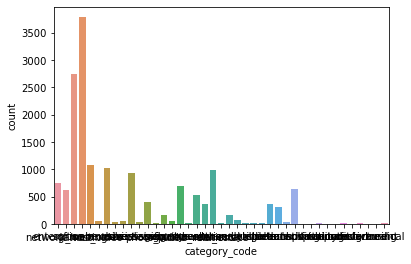

In [3]:
print(category.category_code.value_counts())
sns.countplot(x="category_code",data=category);

Even though web and software are very profitable, there are too many companies in those categories. We will try to compare profit in each sector.

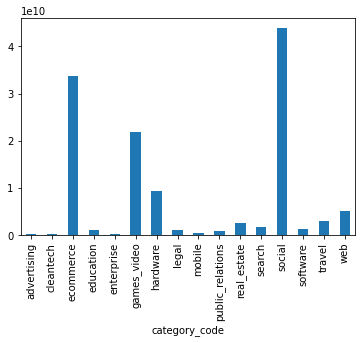

In [4]:
valuation = db.companies.find({'ipo.valuation_amount':{'$ne' : None}},{'_id':0,'category_code':1,'name':1,'ipo.valuation_amount':1})
valuation= pd.DataFrame(valuation)
for i in range(61):
    valuation.ipo[i] = int(valuation.ipo[i]['valuation_amount'])
new = valuation.groupby('category_code').agg({'ipo':['sum','count']})['ipo']
average = new['sum']/new['count']
average.plot.bar();

We can see that social and ecommerce have bigger valuations on average. If we take into account both graphs, Social is not that over populated and has a high value. But it's a really competitive market. Tech companies are almost overvalued so they can sell stocks in the market, normally they are valued 3x revenue or at other price if they are not earning money yet.

Let's check how many of these companies have deadpooled, this maybe can tell us where the investments are not going. Start ups need cash flow and they need to raise funds to become big fast.

It seems that most of them seem to get enough funds. Also a good idea to look at Deadpooled companies and check why they "dried". Seems like tech companies are less likely to succeed in the long run. Also for these types of companies they need a lot of funding to succeed.

In [5]:
funds = list(db.companies.find({},{'_id':0,'category_code':1,'total_money_raised':1}))
funds = pd.DataFrame(funds)
#eliminating $0 since we don't knwo if it means 0 funds or not specified
funds=funds[~(funds['total_money_raised']=='$0')]
funds.total_money_raised.value_counts()

$1M       93
$10M      90
$5M       84
$2M       79
$500k     62
          ..
$2.93M     1
$38.8M     1
€41M       1
€424k      1
$520M      1
Name: total_money_raised, Length: 1477, dtype: int64

After checking all of the things above, success rate, founding money, and market. We are going to pick an e-commerce business.

In [6]:
ecommerce = list(db.companies.find({'category_code':'ecommerce'},{'_id':0,'name':1}))
ecommerce = pd.DataFrame(ecommerce)
ecommerce

,name
0,Wize
1,Zlio
2,TheFind
3,Zazzle
4,Kaboodle
...,...
683,Top Rated Website Designers
684,EscapeHomes
685,Lift Media
686,Nokaut


The advantage of an ecommerce is that location of the offices is not that important, but what is important is a storage location/distribution center near all the major delivery companies.
But where are these companies located?


In [7]:
from pandas.io.json import json_normalize
state = db.companies.find({'$and':[{'category_code':'ecommerce'},{'offices.state_code':{'$exists':True}}]},{'_id':0,'name':1,'offices':1})
state= json_normalize(state,'offices',['name'])
state = state[['name','state_code','city', 'country_code','latitude','longitude']]
state

<ipython-input-7-9fceef9002e9>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  state= json_normalize(state,'offices',['name'])


,name,state_code,city,country_code,latitude,longitude
0,Wize,CA,Burlingame,USA,37.559287,-122.302262
1,Zlio,None,Paris,FRA,48.862825,2.381836
2,TheFind,CA,Mountain View,USA,37.391502,-122.073463
3,Zazzle,CA,Redwood City,USA,37.510854,-122.201356
4,Kaboodle,CA,Sunnyvale,USA,37.382162,-122.036301
...,...,...,...,...,...,...
618,Top Rated Website Designers,CA,Los Angeles,USA,33.993326,-118.398784
619,Top Rated Website Designers,CA,San Diego,USA,33.141212,-117.320512
620,EscapeHomes,TX,Austin,USA,NaN,NaN
621,Lift Media,CA,San Francisco,USA,NaN,NaN


In [8]:
state.groupby('state_code')['city'].count().sort_values()[:-10:-1]

state_code
CA    124
NY     48
FL     18
WA     17
TX     16
MA     15
IL     14
CO     10
NC      9
Name: city, dtype: int64

The top ten states with ecommerce are these ones. California and New York are big cities, easy access to delivery and fast delivery, but high rents. So FL, WA and TX are the most viable. 

If we plan to sell in Mexico too, Texas is the best option since it's close to the border and there are several 

In [9]:
texas =state[state['state_code']=='TX']
texas = texas.dropna().reset_index()

In [10]:
import folium
map1 = folium.Map(location=[30.9937281,-97.5196869])

for i in range(len(texas['latitude'])):

    folium.Marker([texas['latitude'][i], texas['longitude'][i]], icon=folium.Icon(color='green')).add_to(map1)

    
sw = texas[['latitude', 'longitude']].min().values.tolist()
ne = texas[['latitude', 'longitude']].max().values.tolist()

map1.fit_bounds([sw, ne]) 
map1

We had a wrong address  becuase it appaears in Washington even though
it is marked as TX.
We can choose one of these 3 cities.